In [53]:
import matplotlib.gridspec as gridspec
import scqubits
import numpy as np
from CoupledQuantumSystems.visualization import *
from CoupledQuantumSystems.systems import *
from tqdm import tqdm
import pickle
import scipy
from CoupledQuantumSystems.qobj_manip import *
from matplotlib.ticker import ScalarFormatter
import scipy
from skimage.transform import radon
import numpy as np
from CoupledQuantumSystems.mcsolve_utils import *
import matplotlib.pyplot as plt

from typing import List
import matplotlib.gridspec as gridspec

import sys
original_sys_path = sys.path.copy()
from CoupledQuantumSystems.visualization import *


In [ ]:
ef_folder = '../deprecated_ef_3,4,20.5'
gf_folder = '../gf_new'
ef_system = f'{ef_folder}/ef_mcsolve_system_g025.pkl'
gf_system = f'{gf_folder}/gf_mcsolve_system_g3a01k002.pkl'

ef_results = f'{ef_folder}/mcsolve_results_with_product_basis_g2a01k005.pkl'
gf_results = f'{gf_folder}/mcsolve_results_with_product_basis.pkl'

ef_SNR =  f'{ef_folder}/numbers_for_SNR_g2a01k005.pkl'
gf_SNR = f'{gf_folder}/numbers_for_SNR.pkl'

with open(ef_system, 'rb') as f:
    system_ef = pickle.load(f)
qbt0 = system_ef.qbt
print(f"loaded system_ef")
with open(gf_system, 'rb') as f:
    system_gf = pickle.load(f)
qbt1 = system_gf.qbt
print(f"loaded system_gf")

with open(ef_results, 'rb') as f:
    results_ef = pickle.load(f)
print(f"loaded results_ef")
with open(gf_results, 'rb') as f:
    results_gf = pickle.load(f)
print(f"loaded results_gf")

with open(f'{ef_folder}/husimi_data_time_slices_5step_g25a01k005.pkl', 'rb') as f:
    ef_qfunc_results = pickle.load(f)
print(f"loaded ef_qfunc_results")
with open(f'{gf_folder}/husimi_data_time_slices.pkl', 'rb') as f:
    gf_qfunc_results = pickle.load(f)
print(f"loaded gf_qfunc_results")

In [6]:
linestyles = ['-','-','-']
linewidth_list = [1.75,1.75,1.75]

colors = ['#4999c3','#d5373d','#6cbe80']

In [8]:
n_evals = 20
qls = [0,1,2]
max_ol = 50
max_ql = 20

In [75]:
def get_shift_accurate(ele,omega_i, omega_j, omega_r):
    return abs(ele)**2 / (omega_j-omega_i-omega_r) - abs(ele)**2 / (omega_i-omega_j-omega_r)

def plot_chi_curve(ax,Er_array,shift_array,label,color,linestyle,linewidth):
    ax.plot(Er_array,shift_array,label=label,color=color,linestyle=linestyle,linewidth=linewidth)
    # # Step-1: identify continuous segments of the curve
    # # Step-2: plot each segment separately
    # # Step-3: use dashed lines to connect the segments
    # shifts = np.array(shift_array)
    
    # # Find discontinuities using numpy operations
    # diff_shifts = np.abs(np.diff(shifts))
    # discontinuities = np.where(diff_shifts > 1.0)[0]
    
    # # Add vertical lines at discontinuities
    # x_disconts = (Er_array[discontinuities] + Er_array[discontinuities + 1]) / 2
    # for x_discont in x_disconts:
    #     ax.axvline(x=x_discont, color=color, linestyle='--', alpha=0.5, linewidth=linewidth)
    
    # # Create mask for valid segments
    # mask = np.ones_like(shifts, dtype=bool)
    # mask[discontinuities + 1] = False
    
    # # Plot the continuous segments
    # ax.plot(Er_array[mask], shifts[mask], color=color, linestyle=linestyle, 
    #        linewidth=linewidth, label=label)

    
def plot_sweep_er(ax,qbt,g,Er_array,ymin,ymax,marker_x,marker_y,x_offset,y_offset,labeled_transitions):
    matrix =  qbt.matrixelement_table(operator = "n_operator",evals_count=n_evals)
    evals = qbt.eigenvals(n_evals)
    for ql  in qls:
        shift_from_qubit_transition = []
        for Er in tqdm(Er_array, desc = "Er loop"):
            shifts = [get_shift_accurate(matrix[ql,ql2], evals[ql2], evals[ql], Er) for ql2 in range(n_evals)] 
            shift_from_qubit_transition.append(sum(shifts)*100 * g)
        plot_chi_curve(ax,Er_array,np.array(shift_from_qubit_transition),label=rf'$\chi_{ql}$',color = colors[ql], linestyle = linestyles[ql],linewidth = linewidth_list[ql])
    ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    ax.set_xlim(Er_array[0],Er_array[-1])
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(rf'$\omega_r$')
    ax.legend(loc= 'center',bbox_to_anchor = (1.2,0.5),handlelength=0.5)
    ax.set_xlabel(rf'$\omega_r$ (GHz)')
    ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()])
    ax.set_ylabel(r'$\chi/2\pi$ (MHz)')
    ax.scatter(marker_x, marker_y, marker='*', color='black', s=80,alpha=0.5,zorder=10)
    for transition in labeled_transitions:
        ax.text(evals[transition[1]]-evals[transition[0]]+x_offset,y_offset,f"{transition[0]}-{transition[1]}",color = colors[transition[0]],fontweight='bold')


def plot_sweep_er_ef(ax):
    plot_sweep_er(ax,
                  qbt= qbt0,
                  g=0.2,
                  Er_array = np.linspace(6.2,7.0,int(1e4)),
                  ymin=0.5,
                  ymax=2,
                  marker_x=6.8,
                  marker_y=1.15,
                  x_offset=0.01,y_offset=1.75,labeled_transitions=[(9,2),(10,1),(7,0),(11,2)])

def plot_sweep_er_gf(ax):
    plot_sweep_er(ax,
                  qbt= qbt1,
                  g=0.3,
                  Er_array = np.linspace(11,16,int(1e4)),
                  ymin=-1,
                  ymax=1.5,
                  marker_x=13.6355,
                  marker_y=0.32,
                  x_offset=0.006,y_offset=1,labeled_transitions=[(2,9),(1,10),(0,9),(2,11)])

In [10]:
def plot_ef_alpha(ax):
    epsilon_r = 0.015 *2*np.pi # External driving term
    kappa = 3e-3 # Decay rate of the resonator
    tot_time =400
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 346
    w_d = 6.798175922599341
    frequency_used = -1*w_d
    alpha_arr = (results_ef[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag, color='#4999c3',label = rf'$\alpha_{{\left|0\right>}}$ sim',alpha=1)
    alpha_arr = (results_ef[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag, color='#d5373d',label = rf'$\alpha_{{\left|1\right>}}$ sim',alpha=1)

    ax.set_aspect('equal')
    ax.set_xlabel(rf'Re[$\alpha$]')
    ax.set_ylabel(rf'Im[$\alpha$]', labelpad=-6)
    # ax.legend(loc = 'upper left',prop={'size': 9})
    ax.set_xlim(-11.5,2.5)
    ax.set_ylim(-11,3)
    # ax.set_yticks([0,-4,-8])

def plot_gf_alpha(ax):
    epsilon_r = 0.01*2*np.pi  # External driving term
    kappa = 2e-3 # Decay rate of the resonator
    tot_time =500
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 449
    w_d = 13.6355
    frequency_used = -1* w_d
    alpha_arr = (results_gf[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist)  )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag,color="#4999c3",label = rf'$\alpha_{{\left|0\right>}}$ sim',alpha=1)
    alpha_arr = (results_gf[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag,color="#d5373d",label = rf'$\alpha_{{\left|1\right>}}$ sim',alpha=1)

    ax.set_aspect('equal')
    ax.set_xlabel(rf'Re[$\alpha$]')
    ax.set_ylabel(rf'Im[$\alpha$]', labelpad=-6)
    # ax.legend(loc = 'lower right',prop={'size': 9})
    ax.set_xlim(-2.5,11)
    ax.set_ylim(-8,5.5)
    # ax.set_yticks([5, 0,-5,-10])

lim = 25
xvec = np.linspace(-1*lim,lim,500)
X, Y = np.meshgrid(xvec, xvec)

def plot_qfunc_cdf_contours(ax, q_values,levels = [0.001,0.5,0.99, 0.999],color='black'):
    sorted_q = np.sort(q_values.ravel())
    cumulative_sum = np.cumsum(sorted_q)
    total_sum = cumulative_sum[-1]
    for prob in levels:
        alpha = np.sqrt(1-prob)
        level_value = sorted_q[np.argmax(cumulative_sum >= total_sum * (1 - prob))]
        # fmt = {level_value:f'{1 - prob:.2f}'}   
        contour = ax.contour(X, Y, q_values, levels=[level_value], colors=color,alpha=alpha)
        # ax.clabel(contour, inline=False, fontsize=8, fmt=fmt,colors='black') 

level_to_draw = [0.1,0.5,0.9,0.99]
def plot_ef_qfunc(ax):
    t_indices = [0, 70, 140, 210, 280, 346]
    for t_idx,result in zip(t_indices,ef_qfunc_results):
        q_values_leak, q_values_compu0, q_values_compu1,  theta,y_leak, y_compu0, y_compu1  = result
        plot_qfunc_cdf_contours(ax, q_values_leak,levels = level_to_draw,color = '#4999c3')
        plot_qfunc_cdf_contours(ax, q_values_compu0,levels = level_to_draw,color = "#d5373d")

def plot_gf_qfunc(ax):
    t_indices = [0, 90, 180, 270, 360, 449]
    for t_idx,result in zip(t_indices,gf_qfunc_results):
        q_values_leak, q_values_compu0, q_values_compu1,  theta,y_leak, y_compu0, y_compu1  = result
        plot_qfunc_cdf_contours(ax, q_values_leak,levels = level_to_draw,color = "#4999c3")
        plot_qfunc_cdf_contours(ax, q_values_compu0,levels = level_to_draw,color = '#d5373d')

In [32]:
def plot_ef_SNR(ax):
    efficiency = 1
    kappa = 3e-3 # Decay rate of the resonator
    tot_time =400
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 346
    w_d = 6.798175922599341
    frequency_used = -1*w_d
    alpha_arr_0 = np.sqrt(kappa)*(results_ef[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    alpha_arr_1 = np.sqrt(kappa)*(results_ef[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    diff_arr = np.abs(alpha_arr_0-alpha_arr_1)
    numerator = np.sqrt(kappa * efficiency) * scipy.integrate.cumulative_trapezoid(diff_arr, tlist[:last_t_idx+1],initial=0)
    denominator =np.sqrt(kappa *  tlist[:last_t_idx+1] / 2 * 2)
    denominator[0]+= 1e-10 # avoid dividing by zero
    SNR = numerator / denominator
    ax.plot(tlist[:last_t_idx+1],SNR,color='black',linestyle='--',label='SNR')


    with open(ef_SNR, 'rb') as file:
        (A_leak_list, mu_leak_list, sigma_leak_list, A_compu_list, mu_compu_list, sigma_compu_list, leak_fit_accuracies, compu_fit_accuracies) = pickle.load(file)
    contrast = np.abs(np.array(mu_leak_list)-np.array(mu_compu_list))
    contrast = np.array(contrast)[:last_t_idx+1]
    weight = contrast
    # weight = np.ones_like(contrast)
    weight_integral = np.trapz(weight,tlist[:last_t_idx+1])
    constant_weight_integral  = np.trapz(np.ones_like(contrast), tlist[:last_t_idx+1])
    weight = weight/(weight_integral / constant_weight_integral)
    integrated_contrast =  np.sqrt(kappa*efficiency)*scipy.integrate.cumulative_trapezoid(np.sqrt(kappa)*contrast*weight, tlist[:last_t_idx+1],initial=0)
    integrated_variance_leakage = kappa* scipy.integrate.cumulative_trapezoid(np.array(sigma_leak_list[:last_t_idx+1])**2 *weight, tlist[:last_t_idx+1],initial=0)
    integrated_variance_compu =kappa* scipy.integrate.cumulative_trapezoid(np.array(sigma_compu_list[:last_t_idx+1])**2 *weight, tlist[:last_t_idx+1],initial=0)
    integrated_sd = np.sqrt(integrated_variance_leakage + integrated_variance_compu)
    snr = integrated_contrast / integrated_sd
    ax.plot(tlist[:last_t_idx+1],snr,color='black',label='SNR-weighted')

    ax.legend(loc = 'upper left',bbox_to_anchor = (-0.1,-0.4))
    ax.set_xlabel(rf't (ns)')
    ax.set_yticks([0,2,4,6,8])

def plot_gf_SNR(ax):
    efficiency = 1
    kappa = 2e-3 # Decay rate of the resonator
    tot_time =500
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 449
    # w_d = 13.6355
    # frequency_used = -1* w_d
    # alpha_arr_0 = np.sqrt(kappa)*(results_gf[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    # alpha_arr_1 = np.sqrt(kappa)*(results_gf[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    # diff_arr = np.abs(alpha_arr_0-alpha_arr_1)
    # numerator = np.sqrt(kappa * efficiency) * scipy.integrate.cumulative_trapezoid(diff_arr, tlist[:last_t_idx+1],initial=0)
    # denominator =np.sqrt(kappa *  tlist[:last_t_idx+1] / 2 * 2)
    # denominator[0]+= 1e-10 # avoid dividing by zero
    # SNR = numerator / denominator
    # ax.plot(tlist[:last_t_idx+1],SNR,color='black',linestyle='--',label='SNR')


    with open(gf_SNR, 'rb') as file:
        (A_leak_list, mu_leak_list, sigma_leak_list, A_compu_list, mu_compu_list, sigma_compu_list, leak_fit_accuracies, compu_fit_accuracies) = pickle.load(file)
    contrast = np.abs(np.array(mu_leak_list)-np.array(mu_compu_list))
    contrast = np.array(contrast)[:last_t_idx+1]
    weight = contrast
    # weight = np.ones_like(contrast)
    weight_integral = np.trapz(weight,tlist[:last_t_idx+1])
    constant_weight_integral  = np.trapz(np.ones_like(contrast), tlist[:last_t_idx+1])
    weight = weight/(weight_integral / constant_weight_integral)
    integrated_contrast =  np.sqrt(kappa*efficiency)*scipy.integrate.cumulative_trapezoid(np.sqrt(kappa)*contrast*weight, tlist[:last_t_idx+1],initial=0)
    integrated_variance_leakage = kappa* scipy.integrate.cumulative_trapezoid(np.array(sigma_leak_list[:last_t_idx+1])**2 *weight, tlist[:last_t_idx+1],initial=0)
    integrated_variance_compu =kappa* scipy.integrate.cumulative_trapezoid(np.array(sigma_compu_list[:last_t_idx+1])**2 *weight, tlist[:last_t_idx+1],initial=0)
    integrated_sd = np.sqrt(integrated_variance_leakage + integrated_variance_compu)
    snr = integrated_contrast / integrated_sd
    ax.plot(tlist[:last_t_idx+1],snr,color='black',label='SNR-weighted')
    ax.set_ylabel(r'SNR')
    # ax.legend(loc = 'upper left',bbox_to_anchor = (-1.5,1.0))
    ax.set_xlabel(rf't (ns)')

Er loop: 100%|██████████| 10000/10000 [00:00<00:00, 85625.48it/s]
 /tmp/ipykernel_5111/4072016190.py: 44RuntimeWarning: invalid value encountered in divide
 /tmp/ipykernel_5111/1665619079.py: 70

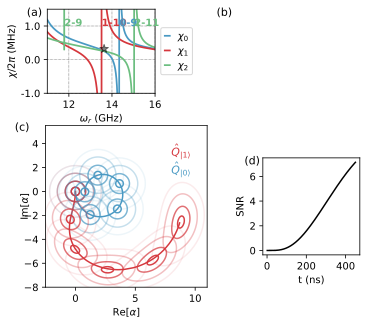

In [76]:
def get_axis():
    fig = plt.figure(figsize=(5, 4.5))
    gs_chi = fig.add_gridspec(nrows=1, ncols=1,left=0.1, right=0.4,bottom=0.7,top = 0.96)
    ax_chi = fig.add_subplot(gs_chi[0])
    size = 0.5
    left = 0.07
    bottom = 0.1
    gs_alpha = fig.add_gridspec(nrows=1, ncols=1,left=left, right=left+size, bottom=bottom,top = bottom+size)
    ax_alpha = fig.add_subplot(gs_alpha[0])
    gs_snr = fig.add_gridspec(nrows=1, ncols=1,left=0.7, right=0.97, bottom=0.2,top = 0.5)
    ax_snr = fig.add_subplot(gs_snr[0])
    return fig, ax_chi, ax_alpha, ax_snr

# # e-f qubit
# fig, ax_chi, ax_alpha, ax_snr = get_axis()
# plot_sweep_er_ef(ax_chi)
# # plot_ef_alpha(ax_alpha)
# plot_ef_qfunc(ax_alpha)
# plot_ef_SNR(ax_snr)
# plt.text(-0.13, 1.02, '(a)(b)', transform=plt.subplot(ax_chi[0]).transAxes, fontsize=11, va='top', color='black')
# plt.text(-0.13, 1.02, '(c)', transform=plt.subplot(ax_alpha[0]).transAxes, fontsize=11, va='top', color='black')
# plt.text(-0.13, 1.02, '(d)', transform=plt.subplot(ax_snr[0]).transAxes, fontsize=11, va='top', color='black')
# plt.savefig("ef_readout.pdf", transparent=True)

fig, ax_chi, ax_alpha, ax_snr = get_axis()
plot_sweep_er_gf(ax_chi)
plot_gf_alpha(ax_alpha)
plot_gf_qfunc(ax_alpha)
ax_alpha.text(8,2.5,r'$\hat{Q}_{|0\rangle}$',fontsize=11,va='top',color = '#4999c3')
ax_alpha.text(8,4,r'$\hat{Q}_{|1\rangle}$',fontsize=11,va='top',color = '#d5373d')
plot_gf_SNR(ax_snr)
ax_chi.text(-0.19, 1.02, '(a)                                                  (b)', transform=ax_chi.transAxes, fontsize=11, va='top', color='black')
ax_alpha.text(-0.19, 1.02, '(c)', transform=ax_alpha.transAxes, fontsize=11, va='top', color='black')
ax_snr.text(-0.19, 1.02, '(d)', transform=ax_snr.transAxes, fontsize=11, va='top', color='black')
# plt.tight_layout()
plt.savefig("gf_readout.pdf", transparent=True)

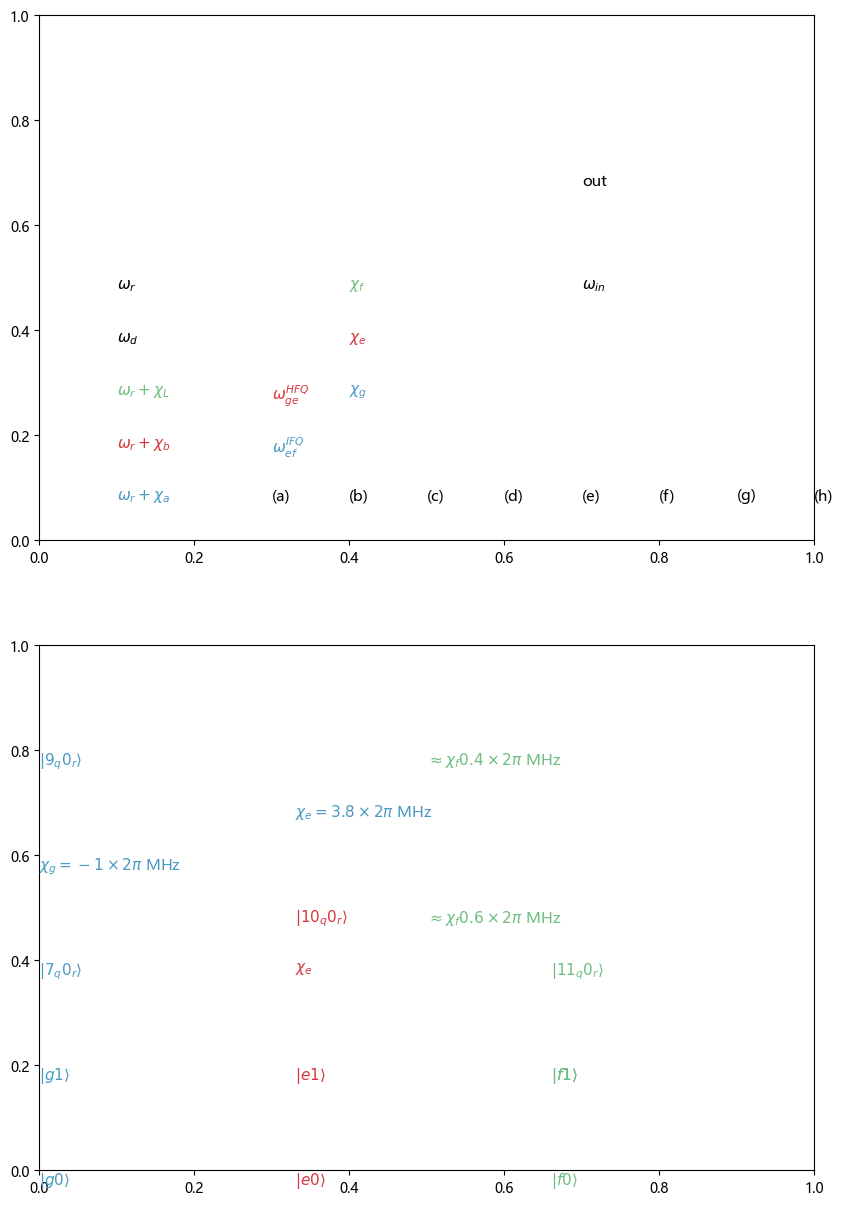

In [7]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(2,1,figsize=(10,15))
ax1,ax2 = axes
ax1.text(0.1,0.1,r"$\omega_r+\chi_a$",fontsize=11,va='top',color = '#4999c3')
ax1.text(0.1,0.2,r"$\omega_r+\chi_b$",fontsize=11,va='top',color = '#d5373d')
ax1.text(0.1,0.3,r"$\omega_r+\chi_L$",fontsize=11,va='top',color = '#6cbe80')

ax1.text(0.1,0.4,r"$\omega_d$",fontsize=11,va='top')

ax1.text(0.1,0.5,r"$\omega_r$",fontsize=11,va='top')

ax1.text(0.3,0.1,"(a)",fontsize=11,va='top')
ax1.text(0.4,0.1,"(b)",fontsize=11,va='top')
ax1.text(0.5,0.1,"(c)",fontsize=11,va='top')
ax1.text(0.6,0.1,"(d)",fontsize=11,va='top')
ax1.text(0.7,0.1,"(e)",fontsize=11,va='top')
ax1.text(0.8,0.1,"(f)",fontsize=11,va='top')
ax1.text(0.9,0.1,"(g)",fontsize=11,va='top')
ax1.text(1.0,0.1,"(h)",fontsize=11,va='top')


ax1.text(0.3,0.2,r"$\omega_{ef}^{IFQ}$",fontsize=11,va='top',color = '#4999c3')
ax1.text(0.3,0.3,r"$\omega_{ge}^{HFQ}$",fontsize=11,va='top',color = '#d5373d')

ax1.text(0.4,0.3,r"$\chi_g$",fontsize=11,va='top',color = '#4999c3')
ax1.text(0.4,0.4,r"$\chi_e$",fontsize=11,va='top',color = '#d5373d')
ax1.text(0.4,0.5,r"$\chi_f$",fontsize=11,va='top',color = '#6cbe80')

ax1.text(0.7,0.5,r"$\omega_{in}$",fontsize=11,va='top',)
ax1.text(0.7,0.7,r"out",fontsize=11,va='top',)


ax2.text(0,0.0, r'$|g0\rangle$', fontsize=11, va='top', color='#4999c3')
ax2.text(0,0.2, r'$|g1\rangle$', fontsize=11, va='top', color='#4999c3')
ax2.text(0,0.4, r'$|7_q 0_r\rangle$', fontsize=11, va='top', color='#4999c3')
ax2.text(0,0.6, r'$\chi_g = -1\times 2\pi$ MHz', fontsize=11, va='top', color='#4999c3')
ax2.text(0,0.8, r'$|9_q 0_r\rangle$', fontsize=11, va='top', color='#4999c3')

ax2.text(0.33,0.0, r'$|e0\rangle$', fontsize=11, va='top', color='#d5373d')
ax2.text(0.33,0.2, r'$|e1\rangle$', fontsize=11, va='top', color='#d5373d')
ax2.text(0.33,0.4, r'$\chi_e$', fontsize=11, va='top', color='#d5373d')
ax2.text(0.33,0.5, r'$|10_q 0_r\rangle$', fontsize=11, va='top', color='#d5373d')

ax2.text(0.66,0.0, r'$|f0\rangle$', fontsize=11, va='top', color='#6cbe80')
ax2.text(0.66,0.2, r'$|f1\rangle$', fontsize=11, va='top', color='#6cbe80')
ax2.text(0.5,0.5, r'$\approx \chi_f 0.6 \times 2\pi$ MHz', fontsize=11, va='top', color='#6cbe80')
ax2.text(0.66,0.4, r'$|11_q 0_r\rangle$', fontsize=11, va='top', color='#6cbe80')
ax2.text(0.66,0.2, r'$|f1\rangle$', fontsize=11, va='top', color='#6cbe80')

ax2.text(0.33,0.7, r'$\chi_e = 3.8\times 2\pi$ MHz', fontsize=11, va='top', color='#4999c3')
ax2.text(0.5,0.8, r'$\approx \chi_f 0.4 \times 2\pi$ MHz', fontsize=11, va='top', color='#6cbe80')




plt.savefig("Fig2.pdf", transparent=True)





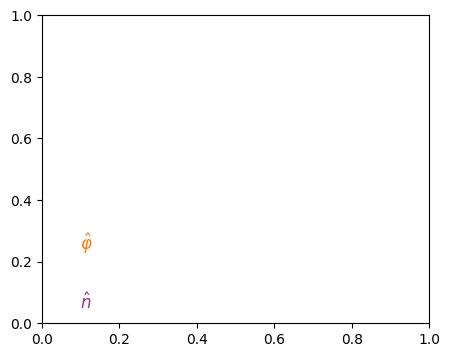

In [5]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.text(0.1,0.1,r"$\hat{n}$",fontsize=12,va='top',color = '#983295')
ax.text(0.1,0.3,r"$\hat{\varphi}$",fontsize=12,va='top',color = '#ff7b15')
fig.savefig('texts.pdf')